# 画像分類AIアプリ
___

## S3バケット、Dockerを指定

In [1]:
#1

%%time
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket='sagemaker-binary-classification-3-3'

containers = {'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest
CPU times: user 739 ms, sys: 39.8 ms, total: 779 ms
Wall time: 1.1 s


## トレーニング用のパラメータを指定

In [3]:
#2

num_layers = 50

image_shape = "3,224,224"

num_training_samples = 1891 

num_classes = 2

mini_batch_size =  16 

epochs = 10

learning_rate = 0.01

use_pretrained_model = 1

optimizer = 'sgd'

In [5]:
#3

%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')

job_name_prefix = 'sagemaker-inst'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "use_pretrained_model": str(use_pretrained_model)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },

    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-inst-2022-03-05-17-36-04

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-binary-classification-3-3/train', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 59.8 ms, sys: 11.7 ms, total: 71.5 ms
Wall time: 136 ms


## トレーニングの開始

In [6]:
#4

sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))


Training job current status: InProgress
Training job ended with status: Completed


In [7]:
#5

training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


### トレインデータと検証データの精度確認

Maximum validation accuracy: 0.924107 


<Figure size 432x288 with 0 Axes>

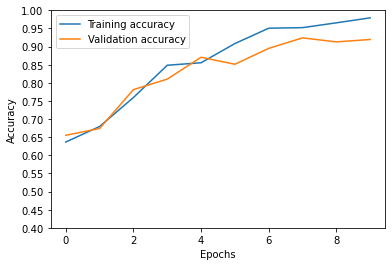

In [10]:
#6

import boto3
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

client = boto3.client('logs')

lgn='/aws/sagemaker/TrainingJobs'

lsn=job_name+'/'+'algo-1-1646501929'
log=client.get_log_events(logGroupName=lgn, logStreamName=lsn)

trn_accs=[]
val_accs=[]
for e in log['events']:
  msg=e['message']
  if 'Validation-accuracy' in msg:
        val = msg.split("=")
        val = val[1]
        val_accs.append(float(val))
  if 'Train-accuracy' in msg:
        trn = msg.split("=")
        trn = trn[1]
        trn_accs.append(float(trn))

print("Maximum validation accuracy: %f " % max(val_accs))
plt.clf()
fig, ax = plt.subplots()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
trn_plot, = ax.plot(range(epochs), trn_accs, label="Training accuracy")
val_plot, = ax.plot(range(epochs), val_accs, label="Validation accuracy")
plt.legend(handles=[trn_plot,val_plot])
ax.yaxis.set_ticks(np.arange(0.4, 1.05, 0.05))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.show()


### 推論

### モデル作成

In [11]:
#7

%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="image-classification-cifar-transfer"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
containers = {'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest'}
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

image-classification-cifar-transfer
s3://sagemaker-binary-classification-3-3/sagemaker-inst/output/sagemaker-inst-2022-03-05-17-36-04/output/model.tar.gz
arn:aws:sagemaker:us-east-1:651239393195:model/image-classification-cifar-transfer
CPU times: user 78 ms, sys: 24.8 ms, total: 103 ms
Wall time: 564 ms


### エンドポイントの設定

In [12]:
#8

from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: sagemaker-inst-epc--2022-03-05-17-46-55
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:651239393195:endpoint-config/sagemaker-inst-epc--2022-03-05-17-46-55


### エンドポイントの作成

In [13]:
#9

%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: sagemaker-inst-ep--2022-03-05-17-46-55
EndpointArn = arn:aws:sagemaker:us-east-1:651239393195:endpoint/sagemaker-inst-ep--2022-03-05-17-46-55
CPU times: user 15.4 ms, sys: 186 µs, total: 15.6 ms
Wall time: 336 ms


In [14]:
#10

response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


### テストデータを使って精度確認

In [15]:
#11
mport boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

In [18]:
#12
s3_client = boto3.client('s3')
data_bucket_name='sagemaker-binary-classification-3-3'

In [19]:
#13
obj_list=s3_client.list_objects(Bucket=data_bucket_name)

In [148]:
#14
test_img_list=[]
test_label_list=[]
test_label_list_num=[]
for contents in obj_list['Contents']:
    if contents['Key'].split('/')[1] == 'guitar':
        test_img_list.append(contents['Key'])
        test_label_list.append( 'guitar')
        test_label_list_num.append(0)
    elif contents['Key'].split('/')[1] == 'others':
        test_img_list.append(contents['Key'])
        test_label_list.append('others')
        test_label_list_num.append(1)

In [72]:
#15
test_img_list[:5]

['test/guitar/07zO2agX-41.jpg',
 'test/guitar/07zO2agX-42.jpg',
 'test/guitar/07zO2agX-43.jpg',
 'test/guitar/07zO2agX-44.jpg',
 'test/guitar/07zO2agX-45.jpg']

In [73]:
#16
test_label_list[:5]

['guitar', 'guitar', 'guitar', 'guitar', 'guitar']

In [158]:
#17
test_label_list_num[:5]

[0, 0, 0, 0, 0]

In [132]:
#18
from PIL import Image
from sklearn import model_selection
import io
import json
import numpy as np
import seaborn as sns

def predict(test_img):
    response = s3_client.get_object(Bucket=data_bucket_name, Key=test_img)
    response_body = response["Body"].read()
    payload = bytearray(response_body)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload )
    result = response['Body'].read()
    result = json.loads(result)
    index = np.argmax(result)
    object_categories = ['guitar','others']
    return  object_categories[index], result[1]

In [136]:
#19
test_pred_list = []
test_proba_others_list = []
for img  in test_img_list:
    predict_label,  predict_proba_others = predict(img)
    test_pred_list.append(predict_label) 
    test_proba_others_list.append(predict_proba_others)

In [138]:
#20
import sklearn.metrics as me
cf_matrix = me.confusion_matrix(test_label_list, test_pred_list) 

In [139]:
#21
cf_matrix

array([[95,  5],
       [ 8, 92]])

In [140]:
#22
def plot_confusion_matrix(data, labels):
    sns.set(color_codes=True)
    plt.figure(1, figsize=(12, 8))
 
    plt.title("Confusion Matrix",  fontsize=18)
 
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels(labels, fontsize=18)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 

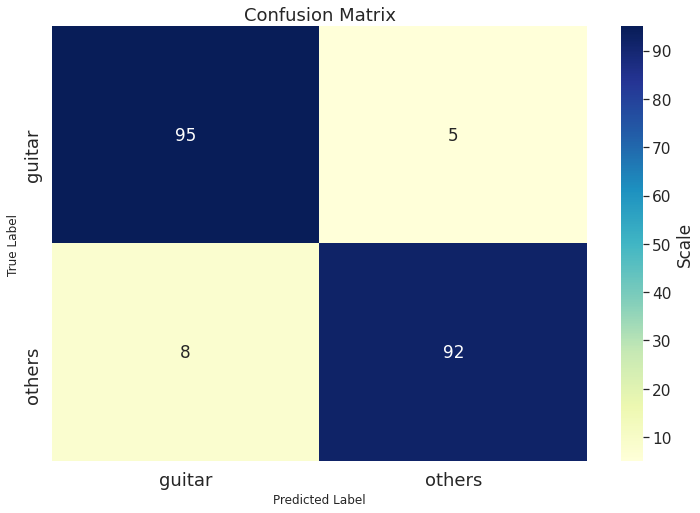

In [142]:
#23
labels = ['guitar','others']
plot_confusion_matrix(cf_matrix, labels)

In [143]:
#24
from sklearn.metrics import classification_report
print(classification_report(test_label_list, test_pred_list))

              precision    recall  f1-score   support

      guitar       0.92      0.95      0.94       100
      others       0.95      0.92      0.93       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



AUC 　: 0.9834


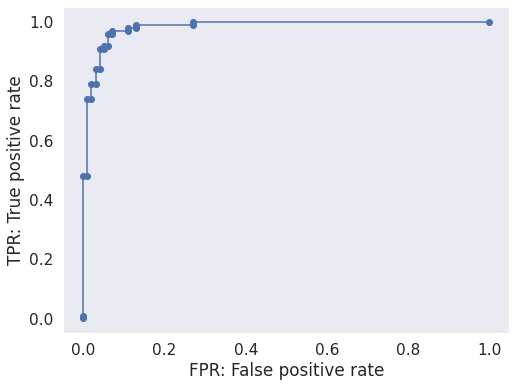

In [155]:
#25
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(test_label_list_num, test_proba_others_list)
print('AUC : {}'.format(auc_score))

fpr_all, tpr_all, th_all  = me.roc_curve(test_label_list_num, test_proba_others_list, pos_label=1)

plt.figure(figsize=(8,6))
plt.plot(fpr_all, tpr_all, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()